In [101]:
# %load data.py
import os
import torch

class Corpus(object):
    def __init__(self, path, batch_size, max_sql):
        self.vocabulary = []
        self.word_id = {}
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))
        self.dset_flag = "train"
        
        ## max_sql means the maximum sequence length
        self.max_sql = max_sql
        self.batch_size = batch_size
        print("size of train set: ",self.train.size(0))
        print("size of valid set: ",self.valid.size(0))
        self.train_batch_num = self.train.size(0) // self.batch_size["train"]
        self.valid_batch_num = self.valid.size(0) // self.batch_size["valid"]
        self.train = self.train.narrow(0, 0, self.batch_size["train"] * self.train_batch_num)
        self.valid = self.valid.narrow(0, 0, self.batch_size["valid"] * self.valid_batch_num)
        self.train = self.train.view(self.batch_size["train"], -1).t().contiguous()
        self.valid = self.valid.view(self.batch_size["valid"], -1).t().contiguous()

    def set_train(self):
        self.dset_flag = "train"
        self.train_si = 0

    def set_valid(self):
        self.dset_flag = "valid"
        self.valid_si = 0

    def tokenize(self, file_name):
        file_lines = open(file_name, 'r').readlines()
        num_of_words = 0
        for line in file_lines:
            words = line.split() + ['<eos>']
            num_of_words += len(words)
            for word in words:
                if word not in self.word_id:
                    self.word_id[word] = len(self.vocabulary)
                    self.vocabulary.append(word)
        file_tokens = torch.LongTensor(num_of_words)
        token_id = 0
        for line in file_lines:
            words = line.split() + ['<eos>']
            for word in words:
                file_tokens[token_id] = self.word_id[word]
                token_id += 1
        return file_tokens

    def get_batch(self):
        ## train_si and valid_si indicates the index of the start point of the current mini-batch
        if self.dset_flag == "train":
            start_index = self.train_si
            seq_len = min(self.max_sql, self.train.size(0)-self.train_si-1)
            data_loader = self.train
            self.train_si = self.train_si + seq_len
        else:
            start_index = self.valid_si
            seq_len = min(self.max_sql, self.valid.size(0)-self.valid_si-1)
            data_loader = self.valid
            self.valid_si = self.valid_si + seq_len
        data = data_loader[start_index:start_index+seq_len, :]
        target = data_loader[start_index+1:start_index+seq_len+1, :].view(-1)

        ## end_flag indicates whether a epoch (train or valid epoch) has been ended
        if self.dset_flag == "train" and self.train_si+1 == self.train.size(0):
            end_flag = True
            self.train_si = 0
        elif self.dset_flag == "valid" and self.valid_si+1 == self.valid.size(0):
            end_flag = True
            self.valid_si = 0
        else:
            end_flag = False
        return data, target, end_flag


In [102]:
# %load model.py
import torch
import torch.nn as nn
from torch.nn import functional as F

class LMModel(nn.Module):
    # Language model is composed of three parts: a word embedding layer, a rnn network and a output layer. 
    # The word embedding layer have input as a sequence of word index (in the vocabulary) and output a sequence of vector where each one is a word embedding. 
    # The rnn network has input of each word embedding and output a hidden feature corresponding to each word embedding.
    # The output layer has input as the hidden feature and output the probability of each word in the vocabulary.
    def __init__(self, nvoc, ninput, nhid, nlayers):
        super(LMModel, self).__init__() 
        self.drop = nn.Dropout(0.5)
        self.encoder = nn.Embedding(nvoc, ninput)
        # WRITE CODE HERE witnin two '#' bar
        ########################################
        # Construct you RNN model here. You can add additional parameters to the function.
        self.ih2h = nn.Linear(ninput+nhid, nhid)
        self.tanh = nn.Tanh()
        self.sigm = nn.Sigmoid()
        self.h2h = nn.Linear(2*nhid,nhid)
        self.rnn = nn.RNN(ninput, nhid, nlayers)
        ########################################
        self.decoder = nn.Linear(nhid, nvoc)
        self.init_weights()

    def init_weights(self):
        init_uniform = 0.1
        self.encoder.weight.data.uniform_(-init_uniform, init_uniform)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_uniform, init_uniform)
    
    def my_RNNcell(self, embeddings, hidden):
        i_cat_h = torch.cat((embeddings, hidden), 2)
        f = self.ih2h(i_cat_h)
        g = self.tanh(f+hidden)
        hidden = self.sigm(f).mul(g)
        output = hidden
        return output, hidden
    
    def my_Encoder(self, embeddings, hidden, Bidirec=False):
        sql = embeddings.shape[0]
        bs = embeddings.shape[1]
        nhid = embeddings.shape[2]
        output = torch.zeros(sql, bs, nhid).to(device)
        rev_output = output
        rev_hidden = hidden
        for i in range(sql-1):
            output[i,:,:], hidden = self.my_RNNcell(embeddings[i].unsqueeze(0), hidden)
            if Bidirec == True:
                rev_output[-1-i,:,:], rev_hidden = self.my_RNNcell(embeddings[-1-i].unsqueeze(0), rev_hidden)
        if Bidirec == True:
            output = self.h2h(torch.cat((output,rev_output),2))
        return output, hidden
        
    def my_AttDecoder(self, encoder_out, last_hidden, embeddings, ndirec=1):
        attout = torch.zeros(encoder_out.size()).to(device)
        decoder_input = torch.zeros(last_hidden.size()).to(device)
        encoder_out = encoder_out.permute(1, 0, 2)
        bs = encoder_out.shape[0]
        sql = encoder_out.shape[1]
        hidden = last_hidden.to(device).detach()
        for i in range(sql-1):
            output, hidden = self.my_RNNcell(decoder_input, hidden)
            hidden = hidden.permute(1,2,0)
            attscore = torch.bmm(encoder_out, hidden)
            soft = F.softmax(attscore, dim=1)
            attdist = encoder_out*soft
            context = attdist.sum(axis=1)
            cont_hid = torch.cat((context,hidden.squeeze(2)),1)
            attout[i,:,:] = self.h2h(cont_hid)
            decoder_input = attout[i,:,:].unsqueeze(0)
            hidden = hidden.permute(2,0,1)
        return attout

    def forward(self, input, hidden, Bidirec=False):
        embeddings = self.drop(self.encoder(input))

        # WRITE CODE HERE within two '#' bar
        ########################################
        # With embeddings, you can get your output here.
        # Output has the dimension of sequence_length * batch_size * number of classes
        rev_hidden = hidden
        output, hidden = self.my_Encoder(embeddings, hidden, Bidirec)
            
        output = self.my_AttDecoder(output, hidden, embeddings)

#         output,hidden = self.rnn(embeddings, hidden)   
        ########################################

        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        #decoded = self.h2o(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden


In [109]:
# %load main.py
import argparse
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim

import data
# import model
import os
import os.path as osp

import time
print('gpu:',torch.cuda.is_available())

parser = argparse.ArgumentParser(description='PyTorch ptb Language Model')
parser.add_argument('--epochs', type=int, default=100,
                    help='upper epoch limit')
parser.add_argument('--train_batch_size', type=int, default=40, metavar='N',
                    help='batch size')
parser.add_argument('--eval_batch_size', type=int, default=40, metavar='N',
                    help='eval batch size')
parser.add_argument('--max_sql', type=int, default=35,
                    help='sequence length')
parser.add_argument('--seed', type=int, default=1234,
                    help='set random seed')
parser.add_argument('--cuda', action='store_true', help='use CUDA device')
parser.add_argument('--gpu_id', type=int, help='GPU device id used')

args = parser.parse_args(args=[])

# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)

# Use gpu or cpu to train
# use_gpu = False

# if use_gpu:
#     torch.cuda.set_device(args.gpu_id)
#     device = torch.device(args.gpu_id)
# else:
#     device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load data
train_batch_size = args.train_batch_size
eval_batch_size = args.eval_batch_size
batch_size = {'train': train_batch_size,'valid':eval_batch_size}
# data_loader = data.Corpus("../data/ptb", batch_size, args.max_sql)
data_loader = Corpus("../data/ptb", batch_size, args.max_sql)
traindata = data_loader.train.to(device)
validdata = data_loader.valid.to(device)
epochs = args.epochs
sql = args.max_sql
        
# WRITE CODE HERE within two '#' bar
########################################
# Build LMModel model (bulid your language model here)
n_input = 500
n_hid = 500
n_layers = 1
n_allchar = len(data_loader.vocabulary)

model = LMModel(nvoc=n_allchar, ninput=n_input, nhid=n_hid, nlayers=n_layers).to(device)

########################################

lr = 2.0484e-4
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9,0.999), lr=lr, weight_decay=0.0001)
# optimizer = torch.optim.Adam(model.parameters(), betas=(0.9,0.999), lr=lr)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.931)  
#epoch100:0.9310 epoch200:0.9649 lr:2.0484e-4
#mymodel 0.9489
#attention

# WRITE CODE HERE within two '#' bar
########################################
# Evaluation Function
# Calculate the average cross-entropy loss between the prediction and the ground truth word.
# And then exp(average cross-entropy loss) is perplexity.
validloss = []
def evaluate():
    data_loader.set_valid()
    hidden = torch.zeros(n_layers,batch_size['valid'],n_hid).to(device)

    for i in range(0,validdata.size(0)-sql,sql):
        hidden = hidden.detach()
        inputs, label, flag = data_loader.get_batch()
        output, hidden = model.forward(inputs.to(device), hidden, Bidirec=True)

        loss = criterion(output.view(-1,output.shape[2]),label.to(device))

    validloss.append(loss.item())
    print('valid loss:',loss.item(),'pp:',torch.exp(loss).item())
#     pass
########################################


# WRITE CODE HERE within two '#' bar
########################################
# Train Function
trainloss = []
def train():    
    data_loader.set_train()
    optimizer.zero_grad()
    hidden = torch.zeros(n_layers,batch_size['train'],n_hid).to(device)
    
    for i in range(0,traindata.size(0)-sql,sql):
        hidden = hidden.detach()
        inputs, label, flag = data_loader.get_batch()
        optimizer.zero_grad()
        output, hidden = model.forward(inputs.to(device), hidden, Bidirec=True)

        loss = criterion(output.view(-1,output.shape[2]),label.to(device))
        nn.utils.clip_grad_norm_(model.parameters(),0.5)
        loss.backward()
        optimizer.step()
        
    trainloss.append(loss.item())
    print('train loss:',loss.item(),'pp:',torch.exp(loss).item())

#     pass 
########################################


# Loop over epochs.
for epoch in range(1, args.epochs+1):
    start = time.time()
    print('epochs:',epoch)
    train()
    evaluate()
    scheduler.step()
    end = time.time()
    print('time:',end-start,'s')
    print('*'*100)

gpu: True
size of train set:  929589
size of valid set:  73760
epochs: 1
train loss: 6.582287788391113 pp: 722.189697265625
valid loss: 6.515632629394531 pp: 675.6212768554688
time: 57.90779733657837 s
****************************************************************************************************
epochs: 2
train loss: 6.474143981933594 pp: 648.1641235351562
valid loss: 6.437375068664551 pp: 624.7646484375
time: 58.959705114364624 s
****************************************************************************************************
epochs: 3
train loss: 6.388561725616455 pp: 595.0001831054688
valid loss: 6.3484930992126465 pp: 571.6306762695312
time: 60.43656516075134 s
****************************************************************************************************
epochs: 4
train loss: 6.098512172698975 pp: 445.1949157714844
valid loss: 6.104654788970947 pp: 447.93798828125
time: 60.22092890739441 s
******************************************************************************

train loss: 1.393028736114502 pp: 4.027028560638428
valid loss: 1.8712390661239624 pp: 6.496340751647949
time: 48.325212717056274 s
****************************************************************************************************
epochs: 36
train loss: 1.393301248550415 pp: 4.028126239776611
valid loss: 1.72758948802948 pp: 5.627073287963867
time: 49.76218056678772 s
****************************************************************************************************
epochs: 37
train loss: 1.3249866962432861 pp: 3.7621355056762695
valid loss: 1.6760088205337524 pp: 5.344183921813965
time: 48.40395498275757 s
****************************************************************************************************
epochs: 38
train loss: 1.3421120643615723 pp: 3.827117919921875
valid loss: 1.6336413621902466 pp: 5.122493743896484
time: 49.063406467437744 s
****************************************************************************************************
epochs: 39
train loss: 1.30985701084

train loss: 1.1745867729187012 pp: 3.236804962158203
valid loss: 1.4609370231628418 pp: 4.309996128082275
time: 52.983487606048584 s
****************************************************************************************************
epochs: 70
train loss: 1.1785106658935547 pp: 3.2495310306549072
valid loss: 1.4226188659667969 pp: 4.1479692459106445
time: 50.05758762359619 s
****************************************************************************************************
epochs: 71
train loss: 1.1970492601394653 pp: 3.3103346824645996
valid loss: 1.4879192113876343 pp: 4.427872180938721
time: 54.77777910232544 s
****************************************************************************************************
epochs: 72
train loss: 1.1601107120513916 pp: 3.19028639793396
valid loss: 1.6421698331832886 pp: 5.166367530822754
time: 50.71821427345276 s
****************************************************************************************************
epochs: 73
train loss: 1.1491312

In [194]:
from nltk.translate.bleu_score import sentence_bleu
max_sql = 35
batch_size = {'train': 1,'valid':1}
data_loader = Corpus("../data/ptb", batch_size, max_sql)
data_loader.set_valid()
bleu_opt = 0
bleu = []
for i in range(0,len(data_loader.valid)-sql,sql):
# for i in range(5):
    inputs, label, flag = data_loader.get_batch()
    hidden = torch.zeros(n_layers,batch_size['valid'],n_hid).to(device)
    output, hidden = model.forward(inputs.to(device), hidden, Bidirec=True)

    reference_ind = torch.max(output.view(-1,output.shape[2]),1)[1].cpu().numpy().tolist()
    candidate_ind = label.cpu().numpy().tolist()
    reference = [[data_loader.vocabulary[i] for i in reference_ind]]
    candidate = [data_loader.vocabulary[i] for i in candidate_ind]
    bleuscore = sentence_bleu(reference, candidate)
    bleu.append(bleuscore)
    if bleuscore > bleu_opt:
        bleu_opt = bleuscore
        reference_opt = reference
        candidate_opt = candidate
        
print('\nSequence length: ',max_sql,'\n')
print('Avg_BLEU: %.4f' % torch.mean(torch.Tensor(bleu)),'\n')
print('='*40,'Optimal Case','='*40)
print('BLEU: %.4f'% bleu_opt)
print('\nReal text:\n'," ".join(candidate_opt))
print('\nPrediction text:\n'," ".join(reference_opt[0]))


Sequence length:  35 

Avg_BLEU: 0.6692 

======================================== Optimal Case ========================================
BLEU: 0.9701

Real text:
 <eos> the smaller stocks in the tokyo market 's second section also posted their biggest decline of the year <eos> the tokyo stock exchange index for the second section fell N or N N to

Prediction text:
 <eos> the smaller stocks in the tokyo market 's second section also posted their biggest decline of the year <eos> the tokyo stock exchange index for the second section fell N or N N the


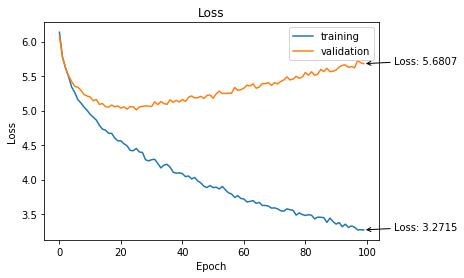

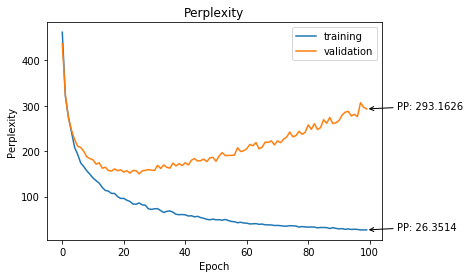

In [29]:
# emb size 1000
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

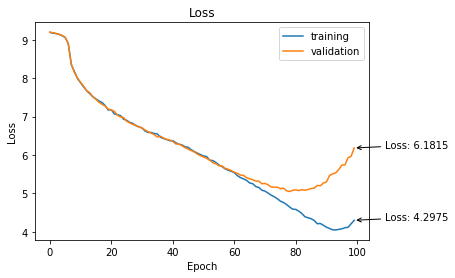

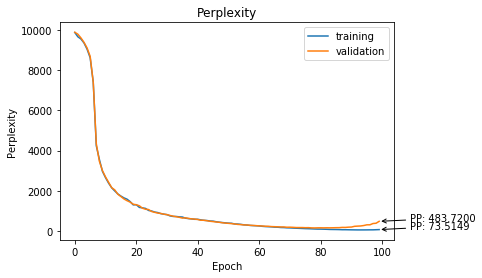

In [34]:
# learning rate strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

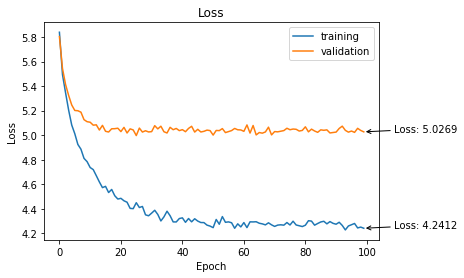

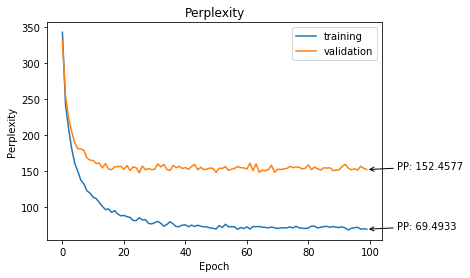

In [39]:
# after learning rate strategy
# 2.0484e-4 ~ 1.6105e-7 -> gamma = 0.931
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()


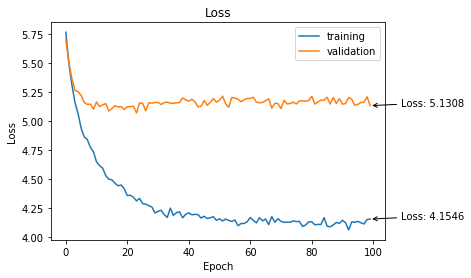

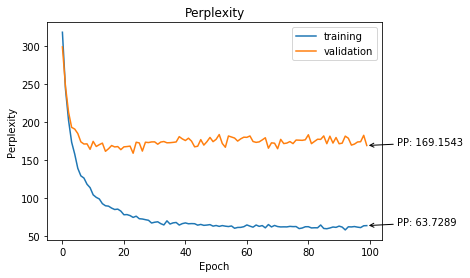

In [44]:
# num layer = 2
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

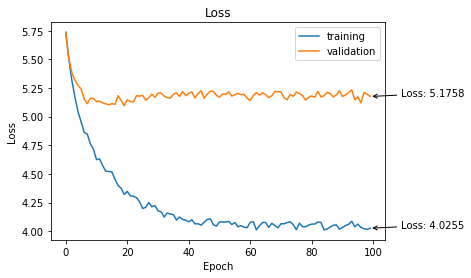

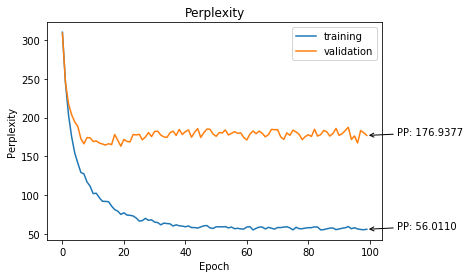

In [46]:
# num layer = 3
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

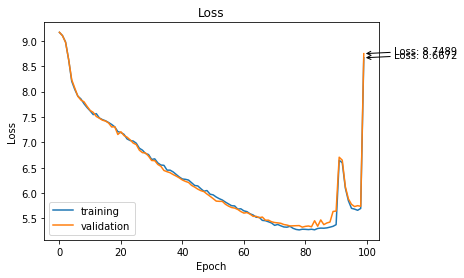

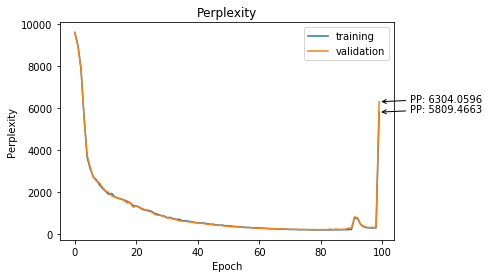

In [60]:
# num layer = 3, weigt decay = 0.001, lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()


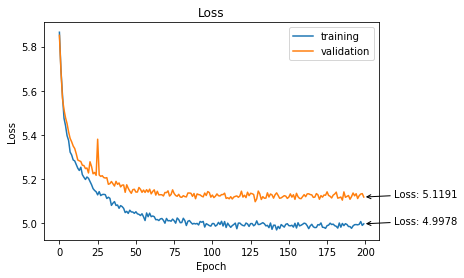

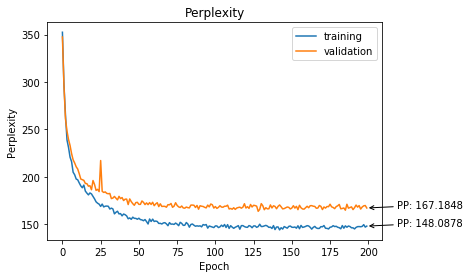

In [63]:
# num layer = 3, weigt decay = 0.001, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

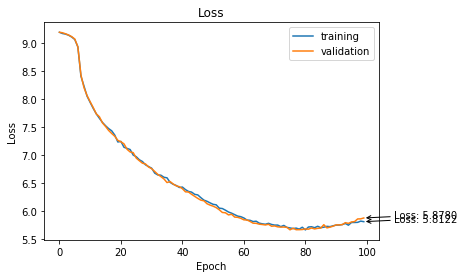

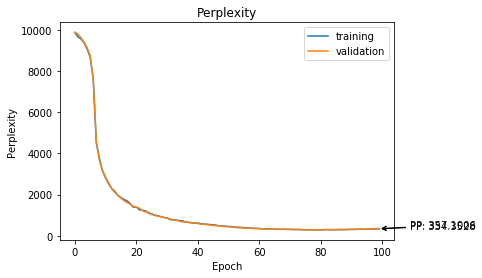

In [65]:
# num layer = 1, weigt decay = 0.001, lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

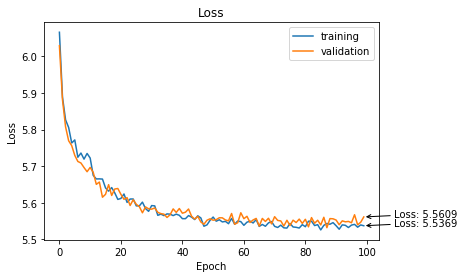

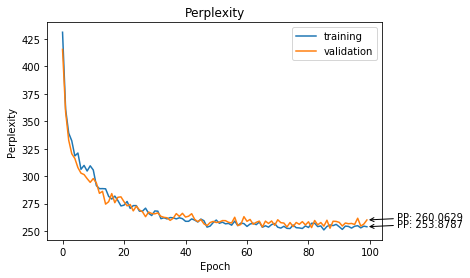

In [67]:
# num layer = 1, weigt decay = 0.001, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

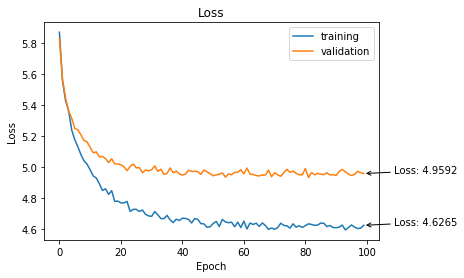

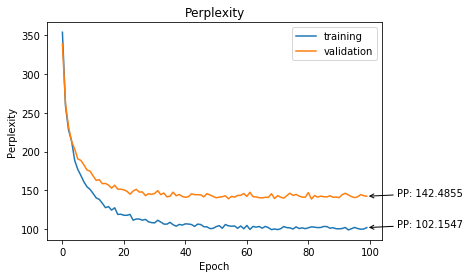

In [69]:
# num layer = 1, weigt decay = 0.0001, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

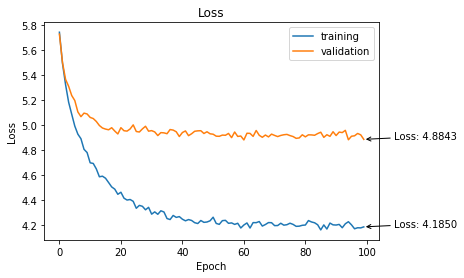

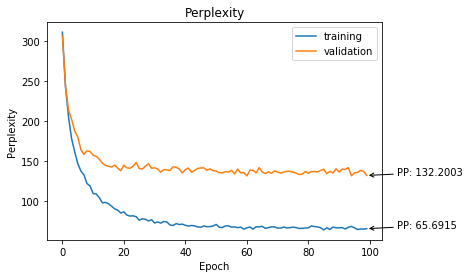

In [71]:
# num layer = 3, weigt decay = 0.0001, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

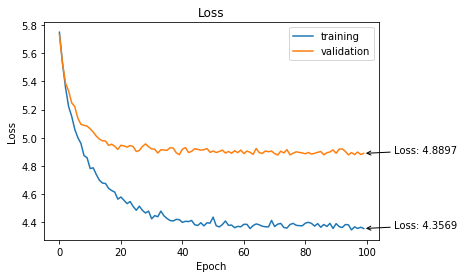

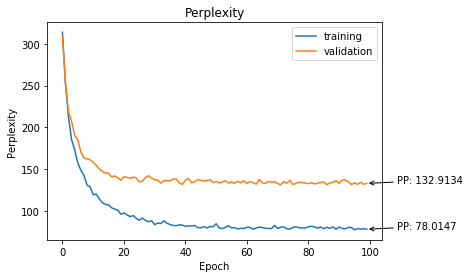

In [75]:
# num layer = 3, weigt decay = 0.0002, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

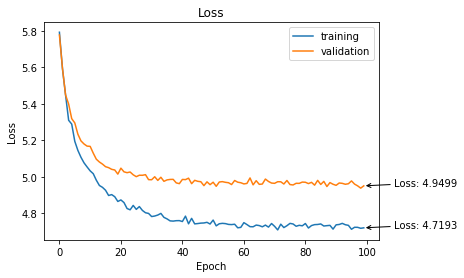

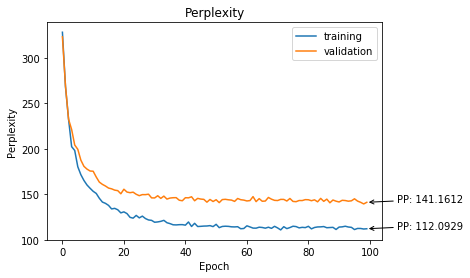

In [73]:
# num layer = 3, weigt decay = 0.0005, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

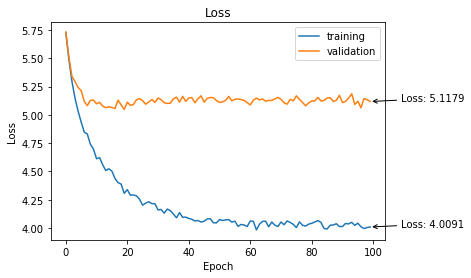

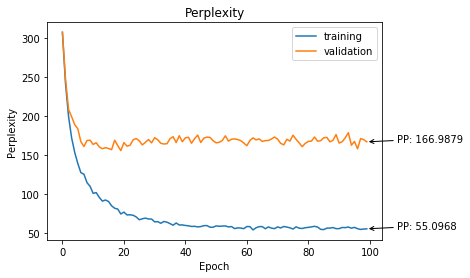

In [78]:
# num layer = 3, weigt decay = 0.00001, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

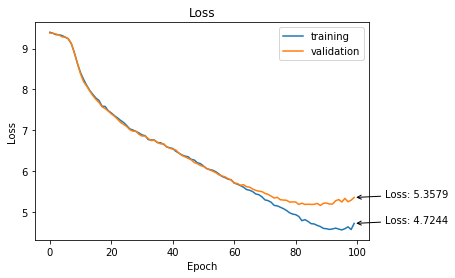

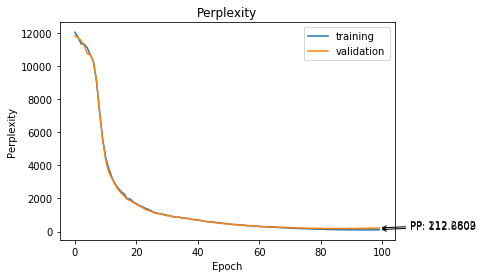

In [198]:
# my model, lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

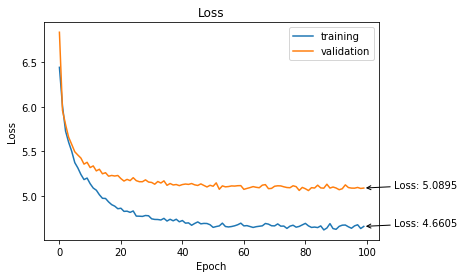

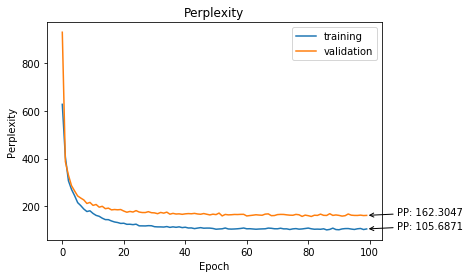

In [208]:
# my model, weight_decay = 5e-6, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

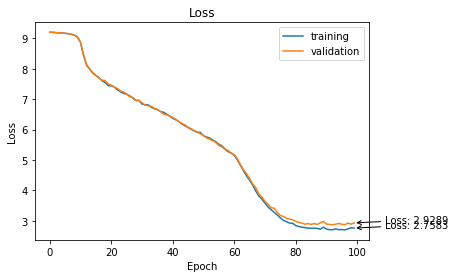

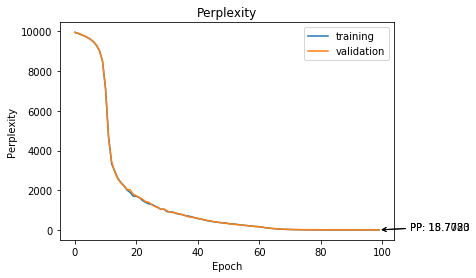

In [151]:
# my model, weight_decay = 0.0001, Bidirectional, lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

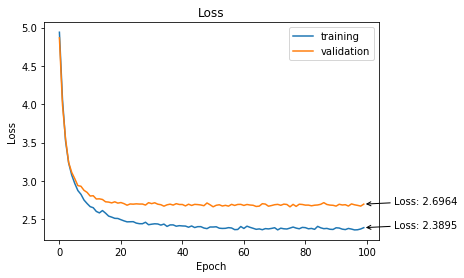

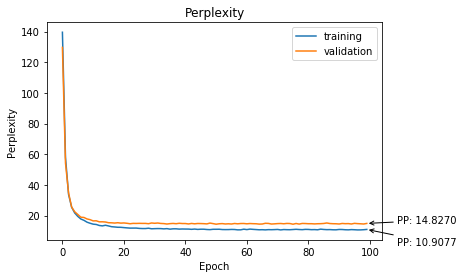

In [167]:
# my model, weight_decay = 0.0001, Bidirectional, after lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt-10), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

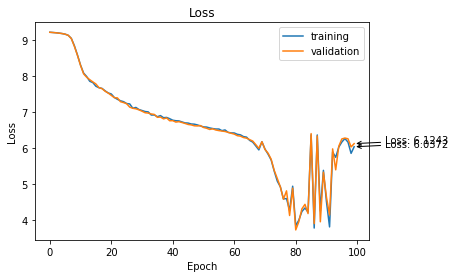

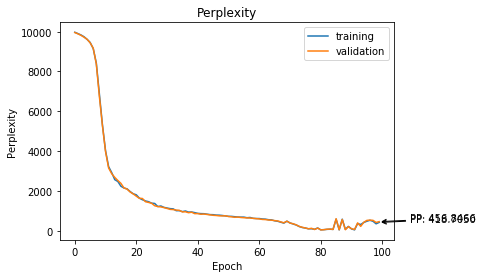

In [107]:
# my model, weight_decay = 0.0001, Bidirectional, Attention, lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt-10), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

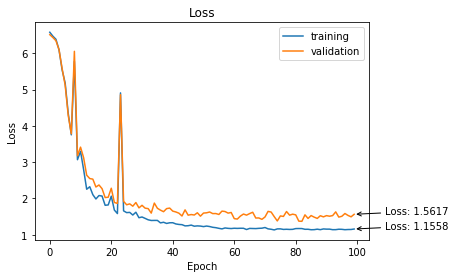

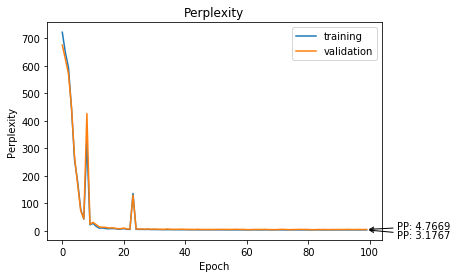

In [115]:
# my model, weight_decay = 0.0001, Bidirectional, Attention, lr strategy
import matplotlib.pyplot as plt

plt.plot(trainloss,label = 'training')
plt.plot(validloss,label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
xt = len(trainloss)-1
yt = trainloss[xt]
plt.annotate('Loss: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = validloss[xv]
plt.annotate('Loss: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()

plt.plot(torch.exp(torch.Tensor(trainloss)),label = 'training')
plt.plot(torch.exp(torch.Tensor(validloss)),label = 'validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
xt = len(trainloss)-1
yt = torch.exp(torch.Tensor(trainloss))[xt]
plt.annotate('PP: {:.4f}'.format(yt), xy = (xt,yt), xytext = (xt*1.1,yt-30), arrowprops=dict(arrowstyle='->'))
xv = len(validloss)-1
yv = torch.exp(torch.Tensor(validloss))[xv]
plt.annotate('PP: {:.4f}'.format(yv), xy = (xv,yv), xytext = (xv*1.1,yv), arrowprops=dict(arrowstyle='->'))
plt.show()